A script to generate a L63s dataset for DAODEN
https://arxiv.org/abs/2009.02296

- Training set: 200 sequences of length of 150.
- Validation set: 50 sequences of length of 150.
- Test set: 50 sequences of length of 1000.
- dt_integration: 0.01

## Config

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import os
import sys
sys.path.append("..")
from tqdm import tqdm
import sdeint
import daoden_utils
np.random.seed(1234)

N_init = 5000

v_mean   = daoden_utils.L63_MEAN.astype(np.float32)
v_std    = daoden_utils.L63_STD.astype(np.float32)
v_range  = daoden_utils.L63_RANGE.astype(np.float32)

In [2]:
### GENERATE SIMULATED DATA (LORENZ-96 MODEL)
class Simulator():
    model_name = 'L63s'
    data_dim   = 3
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
        gamma = 2.0
    dt_integration = 0.01 
    n_ics_train = 200
    n_ics_valid = 50
    n_ics_test = 50
    seq_len_train      = 150
    seq_len_valid      = 150
    seq_len_test       = 1000
    noise_ratio        = 0.09

simulator = Simulator()
v_mean   = daoden_utils.L63_MEAN.astype(np.float32)
v_std    = daoden_utils.L63_STD.astype(np.float32)
v_range  = daoden_utils.L63_RANGE.astype(np.float32)

In [3]:
def Lorenz63s(z,t,sigma,rho,beta,gamma):
    """ Lorenz-63 dynamical model. 
    Args:
        z: the state. shape = (3,)
        t: time
        sigma, rho, beta, gamma: the parapeters of L63s
    Returns:
        dzdt: dz/dt
    """
    x_1 = sigma*(z[1]-z[0])-4*z[0]/(2*gamma)
    x_2 = z[0]*(rho-z[2])-z[1]-4*z[0]/(2*gamma)
    x_3 = z[0]*z[1] - beta*z[2] -8*z[2]/(2*gamma)
    dzdt  = np.array([x_1,x_2,x_3])
    
    return dzdt

def Stoch_Lorenz_63(S,t,
                    sigma=simulator.parameters.sigma, 
                    rho = simulator.parameters.rho, 
                    beta = simulator.parameters.beta, 
                    gamma = simulator.parameters.gamma):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0])-4*S[0]/(2*gamma);
    x_2 = S[0]*(rho-S[2])-S[1] -4*S[1]/(2*gamma);
    x_3 = S[0]*S[1] - beta*S[2] -8*S[2]/(2*gamma);
    dS  = np.array([x_1,x_2,x_3]);
    return dS

def brownian_process(S,t,
                     sigma=simulator.parameters.sigma, 
                     rho = simulator.parameters.rho,
                     beta = simulator.parameters.beta,
                     gamma = simulator.parameters.gamma):
    x_1 = 0.0;
    x_2 = (rho - S[2])/np.sqrt(gamma);
    x_3 = (S[1])/np.sqrt(gamma);
    dS  = np.array([x_1,x_2,x_3]);
    G = np.eye((3))
    np.fill_diagonal(G,dS)
    return G

In [4]:
print(simulator.noise_ratio)
print((simulator.noise_ratio*v_std)**2)
print(simulator.noise_ratio*(v_std**2))

0.09
[0.5042424 0.6540986 0.5907246]
[5.602694  7.2677617 6.5636067]


In [5]:
np.random.seed(1234)

## Generates training sequences

In [6]:
v_range.shape

(3,)

In [7]:
N_init = 5000
ics_train    = v_range*(np.random.rand(simulator.n_ics_train, simulator.data_dim)-.5) + v_mean
seqs_train   = np.zeros((simulator.n_ics_train,simulator.seq_len_train,simulator.data_dim))
obs_train    = np.zeros(seqs_train.shape)
masks_train  = np.zeros(seqs_train.shape)
print(seqs_train.shape)
for idx in range(simulator.n_ics_train):
    x0 = ics_train[idx,:] # shape = (3,)
    tmp = sdeint.itoEuler(Stoch_Lorenz_63, 
                          brownian_process, 
                          x0, 
                          np.arange(0,(simulator.seq_len_train+N_init)*simulator.dt_integration,1e-4)
                         )
    tmp = tmp[::round(simulator.dt_integration/1e-4)]
    seqs_train[idx,:,:] = tmp[N_init:]
    # generate  partial/noisy observations (yo)
    eps = np.random.multivariate_normal(np.zeros(3),
                                        cov=np.diag((simulator.noise_ratio*v_std)**2),
                                        size=simulator.seq_len_train);
    obs_train[idx,:,:] = seqs_train[idx,:,:]+eps
    for d_i in range(simulator.data_dim):
        masks_train[idx,np.random.choice(simulator.seq_len_train, int(simulator.seq_len_train/8),replace=False),d_i] = 1.0

(200, 150, 3)


In [8]:
masks_train.shape

(200, 150, 3)

In [9]:
print(masks_train[0].shape)
print(np.count_nonzero(masks_train[0]))
150*3/8

(150, 3)
54


56.25

### Generates validation sequences

In [10]:
N_init = 5000
ics_valid    = v_range*(np.random.rand(simulator.n_ics_valid, simulator.data_dim)-.5) + v_mean
seqs_valid   = np.zeros((simulator.n_ics_valid,simulator.seq_len_valid,simulator.data_dim))
obs_valid    = np.zeros(seqs_valid.shape)
masks_valid  = np.zeros(seqs_valid.shape)
print(seqs_valid.shape)
for idx in range(simulator.n_ics_valid):
    x0 = ics_valid[idx,:] # shape = (3,)
    tmp = sdeint.itoEuler(Stoch_Lorenz_63, 
                          brownian_process, 
                          x0, 
                          np.arange(0,(simulator.seq_len_valid+N_init)*simulator.dt_integration,1e-4)
                         )
    tmp = tmp[::round(simulator.dt_integration/1e-4)]
    seqs_valid[idx,:,:] = tmp[N_init:]
    # generate  partial/noisy observations (yo)
    eps = np.random.multivariate_normal(np.zeros(3),
                                        cov=np.diag((simulator.noise_ratio*v_std)**2),
                                        size=simulator.seq_len_valid);
    obs_valid[idx,:,:] = seqs_valid[idx,:,:]+eps
    for d_i in range(simulator.data_dim):
        masks_valid[idx,np.random.choice(simulator.seq_len_valid, int(simulator.seq_len_valid/8),replace=False),d_i] = 1.0

(50, 150, 3)


### Generates test sequences

In [11]:
N_init = 5000
ics_test    = v_range*(np.random.rand(simulator.n_ics_test, simulator.data_dim)-.5) + v_mean
seqs_test   = np.zeros((simulator.n_ics_test,simulator.seq_len_test,simulator.data_dim))
obs_test    = np.zeros(seqs_test.shape)
masks_test  = np.zeros(seqs_test.shape)
print(seqs_test.shape)
for idx in range(simulator.n_ics_test):
    x0 = ics_test[idx,:] # shape = (3,)
    tmp = sdeint.itoEuler(Stoch_Lorenz_63, 
                          brownian_process, 
                          x0, 
                          np.arange(0,(simulator.seq_len_test+N_init)*simulator.dt_integration,1e-4)
                         )
    tmp = tmp[::round(simulator.dt_integration/1e-4)]
    seqs_test[idx,:,:] = tmp[N_init:]
    # generate  partial/noisy observations (yo)
    eps = np.random.multivariate_normal(np.zeros(3),
                                        cov=np.diag((simulator.noise_ratio*v_std)**2),
                                        size=simulator.seq_len_test);
    obs_test[idx,:,:] = seqs_test[idx,:,:]+eps
    for d_i in range(simulator.data_dim):
        masks_test[idx,np.random.choice(simulator.seq_len_test, int(simulator.seq_len_test/8),replace=False),d_i] = 1.0

(50, 1000, 3)


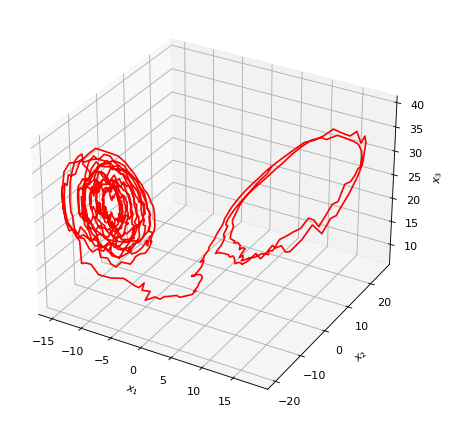

In [19]:
FIG_DPI = 80
fig=plt.figure(figsize=(1920/2/FIG_DPI, 1080/2/FIG_DPI), dpi=FIG_DPI)
daoden_utils.plot_attractor(seqs_test[5,:,:],fig,title="",color='red')

## Save to disk

In [13]:
save_dir = simulator.model_name\
            +"-gamma-"+str(simulator.parameters.gamma)\
            +"-r-"+str(simulator.noise_ratio)+"_att"
print(save_dir)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
np.save(os.path.join(save_dir,"seqs_train.npy"),seqs_train)
np.save(os.path.join(save_dir,"obs_train.npy"),obs_train)
np.save(os.path.join(save_dir,"masks_train.npy"),masks_train)
np.save(os.path.join(save_dir,"masks.npy"),masks_train)

L63s-gamma-2.0-r-0.09_att


In [14]:
np.save(os.path.join(save_dir,"seqs_valid.npy"),seqs_valid)
np.save(os.path.join(save_dir,"obs_valid.npy"),obs_valid)
np.save(os.path.join(save_dir,"masks_valid.npy"),masks_valid)

In [15]:
np.save(os.path.join(save_dir,"seqs_test.npy"),seqs_test)
np.save(os.path.join(save_dir,"obs_test.npy"),obs_test)
np.save(os.path.join(save_dir,"masks_test.npy"),masks_test)